In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [386]:
# Data needs to be preprocessed one batch at a time 
# Original experiment - "full_o_[2-5]"
# Replication experiment - "full_r_[1-5.1]"
fileprefix = "full_r_5.1"
datafolder = '../results'
filepath = '{}/{}_results_anonymized.json'.format(datafolder,fileprefix)


In [387]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [388]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        # Update condition here by setting part_object["condition"]
        # print(part_object["condition"])
        # part_object["condition"] = 0
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/anonymized_data/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

1 w84929691
2 w50175899
3 w29104725
4 w71346398
5 w79800428


In [389]:
part_data.keys()


dict_keys(['w84929691', 'w50175899', 'w29104725', 'w71346398', 'w79800428'])

In [99]:
len(part_data.keys())

27

# Reading Data from Already Created Participant Data Files

In [237]:
fileprefix = "full_o" # pilot_#, final
datafolder = '../results/anonymized_data/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [238]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [239]:
len(part_data.keys())

286

In [240]:
print(",\n".join(part_data.keys()))

w11930620,
w22592146,
w20838185,
w89243441,
w90625846,
w51333812,
w79287731,
w94367310,
w93289383,
w68639087,
w77166227,
w78295288,
w52624552,
w63645500,
w18885932,
w56320192,
w54893015,
w90432099,
w39798461,
w28105407,
w66010444,
w63037649,
w25779052,
w91613593,
w60165223,
w61816170,
w21896350,
w79792462,
w81274284,
w16485452,
w93382793,
w98012153,
w38850667,
w71853600,
w91869494,
w86284612,
w11616808,
w70160301,
w62511750,
w42337564,
w15442413,
w55299912,
w58899451,
w22075787,
w42907931,
w58197514,
w96919407,
w22059943,
w47185265,
w47039169,
w49351698,
w79709549,
w16433856,
w41434252,
w76723214,
w58691235,
w34625717,
w82237922,
w17630596,
w45475537,
w99745213,
w90009660,
w12816576,
w15585591,
w35373844,
w11243396,
w96997703,
w64273145,
w85534180,
w59242215,
w32222186,
w89440040,
w31246579,
w77472466,
w60622137,
w83337711,
w94871918,
w12038840,
w16572819,
w22109560,
w62159434,
w14788080,
w95991684,
w11309130,
w33481383,
w94417301,
w83093858,
w57145962,
w30515482,
w17783226,
w77797645,

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [241]:
# List of participants who are excluded and the reason for exclusion

excluded_parts = []

In [242]:
part_stats_dicts = []
extract_max_trials = 40
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    reached_max_trials = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except Exception as e:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    whatStrategy = ""
    clicksL1 = []
    firstLevelAns = {}
    clickStratsValid = True
    strategyImprove = ""
    difficult = ""
    num_correct_sequences = 0
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
            
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if "num_correct_sequences" in trial['trialdata']:
            num_correct_sequences = trial['trialdata']['num_correct_sequences']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            final_quiz_responses = trial['trialdata']['response']

        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
        
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
            
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                clicks = trial['trialdata']['queries']['click']['state']['target']
                cL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL1.append(cL1)
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = int(trial['trialdata']['response']['effort'])
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial
    
    # Checking if click strategies are invalid
    if firstLevelAns:
        # Criteria 1: clicks made on first level nodes on more than 10% of the trials
        madeL1Clicks = sum([bool(c) for c in clicksL1])/len(clicksL1) >= 0.10
        # Criteria 2: did not pay attention to the values at the first level - average agreement with
        #   negative statements greater than 2 (indifference)
        
        # Assessed by answers to Q5 and Q6
        possible_answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
        
        # "... I did pay attention"
        scoreQ5 = possible_answers.index(firstLevelAns["Q5"])
        # "... I did NOT pay attention"
        scoreQ6 = possible_answers.index(firstLevelAns["Q6"])
        adj_scoreQ6 = len(possible_answers) - scoreQ6 - 1
        
        avg_attn_score = (scoreQ5 + adj_scoreQ6) / 2
        clickStratsValid = not madeL1Clicks or (avg_attn_score >= 2)
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "clicksL1": clicksL1,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "whatStrategy": whatStrategy,
        "strategyImprove": strategyImprove,
        "difficult": difficult,
        "firstLevelAns": firstLevelAns,
        "num_correct_sequences": num_correct_sequences,
        "final_quiz_responses": final_quiz_responses,
        "clickStratsValid": clickStratsValid
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

w11930620
w22592146
w20838185
w89243441
w90625846
w51333812
w79287731
w94367310
w93289383
w68639087
w77166227
w78295288
w52624552
w63645500
w18885932
w18885932 mdp
w56320192
w54893015
w90432099
w39798461
w28105407
w66010444
w63037649
w63037649 mdp
w25779052
w91613593
w60165223
w60165223 beginning
w61816170
w21896350
w21896350 mdp
w79792462
w81274284
w16485452
w93382793
w98012153
w38850667
No data
w71853600
w71853600 mdp
w91869494
!!! More than 40 trials found !!!
w86284612
w11616808
w11616808 mdp
w70160301
w62511750
w62511750 mdp
w42337564
w15442413
w55299912
w55299912 mdp
w58899451
w22075787
w22075787 mdp
w42907931
w58197514
w96919407
w96919407 beginning
w22059943
w22059943 mdp
w47185265
w47185265 beginning
w47039169
w49351698
w49351698 beginning
w79709549
w16433856
w41434252
w76723214
w58691235
w58691235 mdp
w34625717
w82237922
w17630596
w17630596 mdp
w45475537
w99745213
w99745213 mdp
w90009660
No data
w12816576
w15585591
w15585591 mdp
w35373844
w11243396
w96997703
w64273145
w8553418

In [243]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "num_correct_sequences", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

280


,workerId,Beginhit,hitLength,expLength,condition,numQuizAttempts,numTrialsCompleted,mouselabLength,finalScore,num_correct_sequences,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,w11930620,2023-08-04 14:26:13.995660,1575.046,1575.046,1,2.0,40,1141.303,1276.10,0,None,True,6,0,True
1,w22592146,2023-08-04 14:32:32.503896,2186.000,2167.440,1,1.0,40,1258.238,1383.50,0,None,True,3,0,True
2,w20838185,2023-08-04 15:15:22.853993,2017.000,2000.177,0,1.0,40,1254.960,-188.80,0,None,True,3,0,True
3,w89243441,2023-08-04 11:30:49.922336,1084.000,1078.053,0,1.0,40,882.405,1103.20,0,None,True,3,0,True
4,w90625846,2023-08-03 15:32:10.375510,1443.000,1437.708,0,1.0,40,1137.806,2033.80,0,None,True,3,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,w36257203,2023-08-04 14:53:59.094854,1236.000,1230.791,1,1.0,40,1001.713,2201.55,0,None,True,3,0,True
276,w16622391,2023-08-08 08:39:56.647561,37.652,37.652,0,1.0,0,25.447,0.00,0,mdp,False,2,-1,False
277,w28176366,2023-08-04 09:45:03.229233,1888.000,1850.484,0,1.0,40,1138.516,616.20,0,None,True,3,0,True
278,w60047818,2023-08-04 09:41:40.021480,1889.000,1880.190,1,1.0,40,1031.119,884.25,0,None,True,3,0,True


In [244]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

10


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
24,w60165223,2023-08-04 14:30:17.679561,NaT,2023-08-04 14:30:31.944449,6,<redacted>,windows,en-US,20.561,20.561,...,,{},0,None,True,0.0,0.0,-20.561,NaN,NaN
45,w96919407,2023-08-04 09:44:50.707300,NaT,2023-08-04 09:45:12.705083,6,<redacted>,linux,en-ZA,68.022,68.022,...,,{},0,None,True,0.0,0.0,-68.022,NaN,NaN
47,w47185265,2023-08-03 13:54:13.993456,NaT,2023-08-03 13:54:38.050669,6,<redacted>,windows,en-GB,98.598,98.598,...,,{},0,None,True,0.0,0.0,-98.598,NaN,NaN
49,w49351698,2023-08-04 09:36:01.865797,NaT,2023-08-04 09:36:12.315501,6,<redacted>,windows,en-US,10.435,10.435,...,,{},0,None,True,0.0,0.0,-10.435,NaN,NaN
99,w49702558,2023-08-04 09:41:26.295270,NaT,2023-08-04 09:41:41.195316,2,<redacted>,linux,en-ZA,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
147,w67047455,2023-08-04 09:37:21.475766,NaT,2023-08-04 09:37:32.312466,2,<redacted>,windows,en-US,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
195,w78959733,2023-08-08 09:13:07.447577,NaT,2023-08-08 09:13:46.988014,6,<redacted>,linux,en-US,87.234,87.234,...,,{},0,None,True,0.0,0.0,-87.234,NaN,NaN
236,w68466863,2023-08-04 14:29:49.846685,NaT,2023-08-04 14:30:28.807780,2,<redacted>,linux,en-US,27.031,27.031,...,,{},0,None,True,0.0,0.0,-27.031,NaN,NaN
249,w11403524,2023-08-03 13:55:20.116841,NaT,2023-08-03 13:55:35.315398,6,<redacted>,linux,en-ZA,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
251,w99177045,2023-08-04 14:25:59.589083,NaT,2023-08-04 14:26:12.160797,6,<redacted>,linux,en-ZA,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN


In [245]:
for p in immediate_drops.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [246]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

270


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,w11930620,2023-08-04 14:26:13.995660,NaT,2023-08-04 14:27:28.911138,6,<redacted>,windows,en-US,1575.046,1575.046,...,It was not too difficult to improve my perform...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1276.10,1141.303,-433.743,19817.350,0.0
1,w22592146,2023-08-04 14:32:32.503896,2023-08-04 15:08:59.197984,2023-08-04 14:32:49.743396,3,<redacted>,windows,en-GB,2186.000,2167.440,...,It was not that difficult. I just had to make ...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1383.50,1258.238,-909.202,21793.000,0.0
2,w20838185,2023-08-04 15:15:22.853993,2023-08-04 15:49:00.013875,2023-08-04 15:15:33.590384,3,<redacted>,windows,en-ZA,2017.000,2000.177,...,It was difficult because it was like every end...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-188.80,1254.960,-745.217,20300.325,0.0
3,w89243441,2023-08-04 11:30:49.922336,2023-08-04 11:48:54.582933,2023-08-04 11:30:56.071552,3,<redacted>,windows,en-GB,1084.000,1078.053,...,Slightly difficult. The randomised values made...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1103.20,882.405,-195.648,17640.675,0.0
4,w90625846,2023-08-03 15:32:10.375510,2023-08-03 15:56:13.909046,2023-08-03 15:32:15.763888,3,<redacted>,windows,en-GB,1443.000,1437.708,...,The randomness of the location of the big wort...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2033.80,1137.806,-299.902,24060.650,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,w36257203,2023-08-04 14:53:59.094854,2023-08-04 15:14:35.308963,2023-08-04 14:54:03.988015,3,<redacted>,windows,en-US,1236.000,1230.791,...,"I didn't improve much, I think the value at th...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2201.55,1001.713,-229.078,21790.175,0.0
276,w16622391,2023-08-08 08:39:56.647561,NaT,2023-08-08 08:40:00.274717,2,<redacted>,macos,en-US,37.652,37.652,...,,{},0,None,True,0.00,25.447,-12.205,NaN,NaN
277,w28176366,2023-08-04 09:45:03.229233,2023-08-04 10:16:32.217887,2023-08-04 09:45:40.290667,3,<redacted>,windows,en-ZA,1888.000,1850.484,...,It was slightly difficult because of the money...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,616.20,1138.516,-711.968,20907.150,0.0
278,w60047818,2023-08-04 09:41:40.021480,2023-08-04 10:13:09.252172,2023-08-04 09:41:48.013314,3,<redacted>,windows,en-US,1889.000,1880.190,...,it was not that difficult,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,884.25,1031.119,-849.071,19314.325,0.0


In [247]:
# Partial compensation rates

gbp_hourly = 6.00
secondly_rate = gbp_hourly / (3600)

In [248]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
    
early_quitters

3
w71853600, 0.66 1
w24603609, 0.47 0
w18172158, 0.54 0


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_6803/3936591574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
32,w71853600,2023-08-08 08:59:05.802026,NaT,2023-08-08 08:59:19.296760,6,<redacted>,macos,en-GB,395.683,395.683,...,{},0,None,True,0.0,0.0,-395.683,NaN,NaN,0.659472
137,w24603609,2023-08-04 09:39:06.442303,NaT,2023-08-04 09:39:22.472963,6,<redacted>,windows,en-US,283.520,283.520,...,{},0,None,True,0.0,0.0,-283.520,NaN,NaN,0.472533
242,w18172158,2023-08-04 09:43:04.593064,NaT,2023-08-04 09:43:22.100225,6,<redacted>,windows,en-US,326.766,326.766,...,{},0,None,True,0.0,0.0,-326.766,NaN,NaN,0.544610


In [249]:
for p in early_quitters.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [250]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate
print(len(failed_quiz))
print(len(failed_quiz.loc[failed_quiz.numQuizAttempts == 4]))

print_all = True

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    if row["numQuizAttempts"] == 4 or print_all:
        print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

33
3
w18885932, 1.59
w63037649, 1.12
w21896350, 0.39
w62511750, 1.56
w55299912, 0.24
w22059943, 0.60
w58691235, 1.54
w17630596, 0.57
w99745213, 0.19
w31246579, 0.18
w22109560, 0.77
w16626207, 0.74
w13813327, 1.48
w68734620, 1.63
w19919896, 0.75
w83172810, 0.50
w84300886, 0.04
w67943223, 0.55
w56023310, 0.30
w48371852, 3.22
w31812455, 0.31
w43956765, 0.91
w91135227, 0.68
w91959996, 0.74
w20800015, 1.34
w48974030, 1.36
w53946858, 0.29
w67871132, 0.05
w34940702, 0.22
w43384380, 0.17
w21423248, 0.26
w76261230, 0.79
w16622391, 0.04


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_6803/3546998463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
14,w18885932,2023-08-04 09:45:18.317152,NaT,2023-08-04 09:45:39.980288,6,<redacted>,chromeos,en-GB,1523.754,1523.754,...,{},0,None,True,0.0,953.502,-570.252,NaN,NaN,1.589170
21,w63037649,2023-08-04 09:42:09.132514,NaT,2023-08-04 09:43:17.221980,6,<redacted>,windows,en-US,3005.539,3005.539,...,{},0,None,True,0.0,670.227,-2335.312,NaN,NaN,1.117045
26,w21896350,2023-08-04 09:52:18.913099,NaT,2023-08-04 09:52:26.821052,2,<redacted>,windows,en-US,373.388,373.388,...,{},0,None,True,0.0,234.466,-138.922,NaN,NaN,0.390777
37,w62511750,2023-08-04 14:30:38.719953,NaT,2023-08-04 14:30:50.438753,6,<redacted>,windows,en-US,1257.834,1257.834,...,{},0,None,True,0.0,935.241,-322.593,NaN,NaN,1.558735
40,w55299912,2023-08-03 13:57:55.282015,NaT,2023-08-03 13:58:13.501454,6,<redacted>,windows,en-GB,476.378,476.378,...,{},0,None,True,0.0,142.874,-333.504,NaN,NaN,0.238123
46,w22059943,2023-08-04 14:28:10.114908,NaT,2023-08-04 14:28:17.298423,6,<redacted>,windows,en-GB,442.502,442.502,...,{},0,None,True,0.0,362.074,-80.428,NaN,NaN,0.603457
54,w58691235,2023-08-04 14:30:02.732616,NaT,2023-08-04 14:30:16.138472,6,<redacted>,windows,en-US,1164.408,1164.408,...,{},0,None,True,0.0,924.708,-239.700,NaN,NaN,1.541180
57,w17630596,2023-08-04 14:32:40.833922,NaT,2023-08-04 14:33:05.760160,2,<redacted>,windows,en-US,873.418,873.418,...,{},0,None,True,0.0,344.583,-528.835,NaN,NaN,0.574305
59,w99745213,2023-08-03 13:52:57.430552,NaT,2023-08-03 13:53:12.670153,6,<redacted>,macos,en-gb,154.736,154.736,...,{},0,None,True,0.0,113.999,-40.737,NaN,NaN,0.189998
70,w31246579,2023-08-04 14:29:47.282073,NaT,2023-08-04 14:30:11.755890,6,<redacted>,windows,en-GB,733.558,733.558,...,{},0,None,True,0.0,108.017,-625.541,NaN,NaN,0.180028


In [251]:
failed_quiz[["workerId","numQuizAttempts", "dropoutPoint", "numTrialsCompleted"]]

,workerId,numQuizAttempts,dropoutPoint,numTrialsCompleted
14,w18885932,2.0,mdp,0
21,w63037649,2.0,mdp,0
26,w21896350,1.0,mdp,0
37,w62511750,2.0,mdp,0
40,w55299912,1.0,mdp,0
46,w22059943,2.0,mdp,0
54,w58691235,2.0,mdp,0
57,w17630596,2.0,mdp,0
59,w99745213,1.0,mdp,0
70,w31246579,1.0,mdp,0


In [252]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

w18885932	0
w63037649	1
w21896350	0
w62511750	1
w55299912	1
w22059943	1
w58691235	1
w17630596	0
w99745213	0
w31246579	0
w22109560	1
w16626207	0
w13813327	0
w68734620	1
w19919896	0
w83172810	0
w84300886	0
w67943223	1
w56023310	1
w48371852	0
w31812455	0
w43956765	0
w91135227	0
w91959996	0
w20800015	1
w48974030	1
w53946858	0
w67871132	0
w34940702	1
w43384380	1
w21423248	1
w76261230	1
w16622391	0


In [253]:
for p in failed_quiz.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "quizfail"
    })

In [254]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

234


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,w11930620,2023-08-04 14:26:13.995660,NaT,2023-08-04 14:27:28.911138,6,<redacted>,windows,en-US,1575.046,1575.046,...,It was not too difficult to improve my perform...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1276.10,1141.303,-433.743,19817.350,0.0
1,w22592146,2023-08-04 14:32:32.503896,2023-08-04 15:08:59.197984,2023-08-04 14:32:49.743396,3,<redacted>,windows,en-GB,2186.000,2167.440,...,It was not that difficult. I just had to make ...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1383.50,1258.238,-909.202,21793.000,0.0
2,w20838185,2023-08-04 15:15:22.853993,2023-08-04 15:49:00.013875,2023-08-04 15:15:33.590384,3,<redacted>,windows,en-ZA,2017.000,2000.177,...,It was difficult because it was like every end...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-188.80,1254.960,-745.217,20300.325,0.0
3,w89243441,2023-08-04 11:30:49.922336,2023-08-04 11:48:54.582933,2023-08-04 11:30:56.071552,3,<redacted>,windows,en-GB,1084.000,1078.053,...,Slightly difficult. The randomised values made...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1103.20,882.405,-195.648,17640.675,0.0
4,w90625846,2023-08-03 15:32:10.375510,2023-08-03 15:56:13.909046,2023-08-03 15:32:15.763888,3,<redacted>,windows,en-GB,1443.000,1437.708,...,The randomness of the location of the big wort...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2033.80,1137.806,-299.902,24060.650,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,w20913252,2023-08-04 09:41:23.715693,2023-08-04 10:13:27.811889,2023-08-04 09:42:02.215872,3,<redacted>,windows,en-US,1924.000,1883.341,...,it wasn't really difficult to improve my perfo...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,475.00,1294.200,-589.141,21892.225,0.0
275,w36257203,2023-08-04 14:53:59.094854,2023-08-04 15:14:35.308963,2023-08-04 14:54:03.988015,3,<redacted>,windows,en-US,1236.000,1230.791,...,"I didn't improve much, I think the value at th...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2201.55,1001.713,-229.078,21790.175,0.0
277,w28176366,2023-08-04 09:45:03.229233,2023-08-04 10:16:32.217887,2023-08-04 09:45:40.290667,3,<redacted>,windows,en-ZA,1888.000,1850.484,...,It was slightly difficult because of the money...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,616.20,1138.516,-711.968,20907.150,0.0
278,w60047818,2023-08-04 09:41:40.021480,2023-08-04 10:13:09.252172,2023-08-04 09:41:48.013314,3,<redacted>,windows,en-US,1889.000,1880.190,...,it was not that difficult,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,884.25,1031.119,-849.071,19314.325,0.0


In [255]:
data_actually_complete = ["w73948659", "w42683226", "w36371727", "w11309130", "w10978872",
                          "w49640421", "w35031936", "w87353974", "w33159277", "w11930620"]

In [256]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data[["workerId", "numTrialsCompleted", "dropoutPoint", "demographicsAvailable"]]

13


,workerId,numTrialsCompleted,dropoutPoint,demographicsAvailable
35,w11616808,1,mdp,False
42,w22075787,32,mdp,False
61,w15585591,15,mdp,False
66,w85534180,72,mdp,False
96,w77984285,17,mdp,False
109,w69892126,6,mdp,False
125,w80892394,2,mdp,False
148,w61473455,20,mdp,False
178,w50465644,20,mdp,False
191,w64012089,26,mdp,False


In [257]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

w11616808	1
w22075787	1
w15585591	0
w85534180	1
w77984285	0
w69892126	1
w80892394	0
w61473455	1
w50465644	1
w64012089	0
w22146322	0
w75394346	1
w51630855	0


In [258]:

incomplete_full_compensation_eligible = ["w70674374"]
incomplete_partial_compensation_eligible = []


In [259]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))#, row['condition'])
incomplete_partial

0


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus


In [260]:
for p in incomplete_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dataincomplete"
    })

In [261]:
excluded_parts

[{'workerId': 'w60165223', 'reason': 'dropout'},
 {'workerId': 'w96919407', 'reason': 'dropout'},
 {'workerId': 'w47185265', 'reason': 'dropout'},
 {'workerId': 'w49351698', 'reason': 'dropout'},
 {'workerId': 'w49702558', 'reason': 'dropout'},
 {'workerId': 'w67047455', 'reason': 'dropout'},
 {'workerId': 'w78959733', 'reason': 'dropout'},
 {'workerId': 'w68466863', 'reason': 'dropout'},
 {'workerId': 'w11403524', 'reason': 'dropout'},
 {'workerId': 'w99177045', 'reason': 'dropout'},
 {'workerId': 'w71853600', 'reason': 'dropout'},
 {'workerId': 'w24603609', 'reason': 'dropout'},
 {'workerId': 'w18172158', 'reason': 'dropout'},
 {'workerId': 'w18885932', 'reason': 'quizfail'},
 {'workerId': 'w63037649', 'reason': 'quizfail'},
 {'workerId': 'w21896350', 'reason': 'quizfail'},
 {'workerId': 'w62511750', 'reason': 'quizfail'},
 {'workerId': 'w55299912', 'reason': 'quizfail'},
 {'workerId': 'w22059943', 'reason': 'quizfail'},
 {'workerId': 'w58691235', 'reason': 'quizfail'},
 {'workerId':

In [262]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
complete_data

112
109


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,w11930620,2023-08-04 14:26:13.995660,NaT,2023-08-04 14:27:28.911138,6,<redacted>,windows,en-US,1575.046,1575.046,...,It was not too difficult to improve my perform...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1276.10,1141.303,-433.743,19817.350,0.0
1,w22592146,2023-08-04 14:32:32.503896,2023-08-04 15:08:59.197984,2023-08-04 14:32:49.743396,3,<redacted>,windows,en-GB,2186.000,2167.440,...,It was not that difficult. I just had to make ...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1383.50,1258.238,-909.202,21793.000,0.0
2,w20838185,2023-08-04 15:15:22.853993,2023-08-04 15:49:00.013875,2023-08-04 15:15:33.590384,3,<redacted>,windows,en-ZA,2017.000,2000.177,...,It was difficult because it was like every end...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-188.80,1254.960,-745.217,20300.325,0.0
3,w89243441,2023-08-04 11:30:49.922336,2023-08-04 11:48:54.582933,2023-08-04 11:30:56.071552,3,<redacted>,windows,en-GB,1084.000,1078.053,...,Slightly difficult. The randomised values made...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1103.20,882.405,-195.648,17640.675,0.0
4,w90625846,2023-08-03 15:32:10.375510,2023-08-03 15:56:13.909046,2023-08-03 15:32:15.763888,3,<redacted>,windows,en-GB,1443.000,1437.708,...,The randomness of the location of the big wort...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2033.80,1137.806,-299.902,24060.650,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,w20913252,2023-08-04 09:41:23.715693,2023-08-04 10:13:27.811889,2023-08-04 09:42:02.215872,3,<redacted>,windows,en-US,1924.000,1883.341,...,it wasn't really difficult to improve my perfo...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,475.00,1294.200,-589.141,21892.225,0.0
275,w36257203,2023-08-04 14:53:59.094854,2023-08-04 15:14:35.308963,2023-08-04 14:54:03.988015,3,<redacted>,windows,en-US,1236.000,1230.791,...,"I didn't improve much, I think the value at th...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2201.55,1001.713,-229.078,21790.175,0.0
277,w28176366,2023-08-04 09:45:03.229233,2023-08-04 10:16:32.217887,2023-08-04 09:45:40.290667,3,<redacted>,windows,en-ZA,1888.000,1850.484,...,It was slightly difficult because of the money...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,616.20,1138.516,-711.968,20907.150,0.0
278,w60047818,2023-08-04 09:41:40.021480,2023-08-04 10:13:09.252172,2023-08-04 09:41:48.013314,3,<redacted>,windows,en-US,1889.000,1880.190,...,it was not that difficult,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,884.25,1031.119,-849.071,19314.325,0.0


In [263]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

w11930620	1
w22592146	1
w20838185	0
w89243441	0
w90625846	0
w51333812	1
w79287731	1
w94367310	0
w93289383	1
w68639087	0
w77166227	0
w78295288	1
w52624552	1
w63645500	0
w56320192	1
w54893015	0
w90432099	1
w39798461	0
w28105407	1
w66010444	0
w25779052	0
w91613593	0
w61816170	1
w79792462	0
w81274284	1
w16485452	0
w93382793	1
w98012153	1
w91869494	0
w86284612	0
w70160301	0
w42337564	1
w15442413	0
w58899451	0
w42907931	1
w58197514	0
w47039169	1
w79709549	0
w16433856	0
w41434252	0
w76723214	1
w34625717	0
w82237922	0
w45475537	0
w12816576	0
w35373844	1
w11243396	0
w96997703	1
w64273145	0
w59242215	0
w32222186	1
w89440040	1
w77472466	0
w60622137	1
w83337711	0
w94871918	0
w12038840	0
w16572819	1
w62159434	0
w14788080	0
w95991684	1
w11309130	0
w33481383	1
w94417301	0
w83093858	0
w57145962	0
w30515482	1
w17783226	0
w77797645	0
w72664870	1
w96602360	1
w93144615	0
w64871990	0
w92010698	1
w50959616	1
w83126098	0
w75379115	0
w69843463	0
w39656931	0
w67427643	0
w32915339	1
w66301944	0
w14820724	1
w702

In [264]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

221


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,w11930620,2023-08-04 14:26:13.995660,NaT,2023-08-04 14:27:28.911138,6,<redacted>,windows,en-US,1575.046,1575.046,...,It was not too difficult to improve my perform...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1276.10,1141.303,-433.743,19817.350,0.0
1,w22592146,2023-08-04 14:32:32.503896,2023-08-04 15:08:59.197984,2023-08-04 14:32:49.743396,3,<redacted>,windows,en-GB,2186.000,2167.440,...,It was not that difficult. I just had to make ...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1383.50,1258.238,-909.202,21793.000,0.0
2,w20838185,2023-08-04 15:15:22.853993,2023-08-04 15:49:00.013875,2023-08-04 15:15:33.590384,3,<redacted>,windows,en-ZA,2017.000,2000.177,...,It was difficult because it was like every end...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-188.80,1254.960,-745.217,20300.325,0.0
3,w89243441,2023-08-04 11:30:49.922336,2023-08-04 11:48:54.582933,2023-08-04 11:30:56.071552,3,<redacted>,windows,en-GB,1084.000,1078.053,...,Slightly difficult. The randomised values made...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1103.20,882.405,-195.648,17640.675,0.0
4,w90625846,2023-08-03 15:32:10.375510,2023-08-03 15:56:13.909046,2023-08-03 15:32:15.763888,3,<redacted>,windows,en-GB,1443.000,1437.708,...,The randomness of the location of the big wort...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2033.80,1137.806,-299.902,24060.650,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,w20913252,2023-08-04 09:41:23.715693,2023-08-04 10:13:27.811889,2023-08-04 09:42:02.215872,3,<redacted>,windows,en-US,1924.000,1883.341,...,it wasn't really difficult to improve my perfo...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,475.00,1294.200,-589.141,21892.225,0.0
275,w36257203,2023-08-04 14:53:59.094854,2023-08-04 15:14:35.308963,2023-08-04 14:54:03.988015,3,<redacted>,windows,en-US,1236.000,1230.791,...,"I didn't improve much, I think the value at th...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2201.55,1001.713,-229.078,21790.175,0.0
277,w28176366,2023-08-04 09:45:03.229233,2023-08-04 10:16:32.217887,2023-08-04 09:45:40.290667,3,<redacted>,windows,en-ZA,1888.000,1850.484,...,It was slightly difficult because of the money...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,616.20,1138.516,-711.968,20907.150,0.0
278,w60047818,2023-08-04 09:41:40.021480,2023-08-04 10:13:09.252172,2023-08-04 09:41:48.013314,3,<redacted>,windows,en-US,1889.000,1880.190,...,it was not that difficult,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,884.25,1031.119,-849.071,19314.325,0.0


In [266]:
# Calculating the bonus conversion rate for each condition

max_bonus = 1.5

fix_bonus_rate = True
fixed_bonus_rate = 0.000833


bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    if not fix_bonus_rate:
        bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()
    else:
        bonus_rate[condition] = fixed_bonus_rate

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,w11930620,2023-08-04 14:26:13.995660,NaT,2023-08-04 14:27:28.911138,6,<redacted>,windows,en-US,1575.046,1575.046,...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1276.10,1141.303,-433.743,19817.350,0.0,1.062991
1,w22592146,2023-08-04 14:32:32.503896,2023-08-04 15:08:59.197984,2023-08-04 14:32:49.743396,3,<redacted>,windows,en-GB,2186.000,2167.440,...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1383.50,1258.238,-909.202,21793.000,0.0,1.152455
2,w20838185,2023-08-04 15:15:22.853993,2023-08-04 15:49:00.013875,2023-08-04 15:15:33.590384,3,<redacted>,windows,en-ZA,2017.000,2000.177,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-188.80,1254.960,-745.217,20300.325,0.0,-0.157270
3,w89243441,2023-08-04 11:30:49.922336,2023-08-04 11:48:54.582933,2023-08-04 11:30:56.071552,3,<redacted>,windows,en-GB,1084.000,1078.053,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1103.20,882.405,-195.648,17640.675,0.0,0.918966
4,w90625846,2023-08-03 15:32:10.375510,2023-08-03 15:56:13.909046,2023-08-03 15:32:15.763888,3,<redacted>,windows,en-GB,1443.000,1437.708,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2033.80,1137.806,-299.902,24060.650,0.0,1.694155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,w20913252,2023-08-04 09:41:23.715693,2023-08-04 10:13:27.811889,2023-08-04 09:42:02.215872,3,<redacted>,windows,en-US,1924.000,1883.341,...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,475.00,1294.200,-589.141,21892.225,0.0,0.395675
275,w36257203,2023-08-04 14:53:59.094854,2023-08-04 15:14:35.308963,2023-08-04 14:54:03.988015,3,<redacted>,windows,en-US,1236.000,1230.791,...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2201.55,1001.713,-229.078,21790.175,0.0,1.833891
277,w28176366,2023-08-04 09:45:03.229233,2023-08-04 10:16:32.217887,2023-08-04 09:45:40.290667,3,<redacted>,windows,en-ZA,1888.000,1850.484,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,616.20,1138.516,-711.968,20907.150,0.0,0.513295
278,w60047818,2023-08-04 09:41:40.021480,2023-08-04 10:13:09.252172,2023-08-04 09:41:48.013314,3,<redacted>,windows,en-US,1889.000,1880.190,...,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,884.25,1031.119,-849.071,19314.325,0.0,0.736580


In [267]:
# Bonus rates

bonus_rate

{0: 0.000833, 1: 0.000833}

In [268]:
print_bonuses = True

p_list = []
# Printing completed IDs for approval + bonuses
for idx, row in full_bonus_eligible.iterrows():
    p_list.append(row['workerId'])
    if not print_bonuses:
        print('{0}'.format(row['workerId']))
    else:
        if(row['bonus'] > 0):
            print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))


w11930620, 1.06
w22592146, 1.15
w89243441, 0.92
w90625846, 1.69
w51333812, 1.68
w79287731, 0.33
w94367310, 0.92
w93289383, 1.53
w68639087, 1.43
w77166227, 0.78
w78295288, 0.04
w52624552, 1.42
w63645500, 1.86
w56320192, 1.40
w54893015, 0.47
w90432099, 1.60
w39798461, 0.20
w28105407, 1.63
w66010444, 0.96
w25779052, 2.09
w61816170, 1.00
w16485452, 1.54
w93382793, 1.13
w98012153, 1.25
w91869494, 2.16
w86284612, 1.05
w70160301, 1.84
w15442413, 1.77
w58899451, 1.38
w42907931, 1.55
w58197514, 1.05
w79709549, 1.10
w16433856, 0.55
w41434252, 1.57
w76723214, 0.12
w34625717, 1.82
w45475537, 1.77
w12816576, 1.75
w11243396, 1.76
w96997703, 1.62
w64273145, 1.45
w59242215, 0.08
w32222186, 0.06
w89440040, 0.16
w77472466, 1.24
w60622137, 0.33
w83337711, 0.72
w94871918, 0.33
w16572819, 0.39
w62159434, 0.25
w14788080, 1.10
w95991684, 0.77
w11309130, 1.92
w33481383, 0.29
w94417301, 1.12
w83093858, 1.19
w57145962, 1.86
w30515482, 1.35
w77797645, 1.23
w72664870, 1.24
w96602360, 1.56
w93144615, 1.60
w6487199

In [269]:
# Average bonus

print(full_bonus_eligible["bonus"].mean())
print(full_bonus_eligible["bonus"].std())

0.9133878923076922
0.7372657756933458



Condition: 0
Mean: 37.61340119047619
Std: 15.494213808314102
Median: 34.07015833333333

Condition: 1
Mean: 38.373130886850156
Std: 12.096237584602594
Median: 35.51606666666667


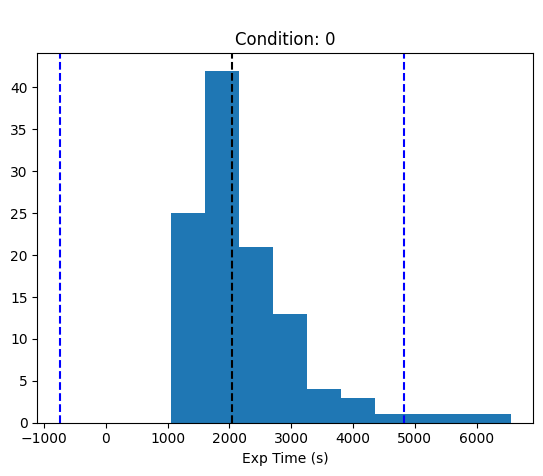

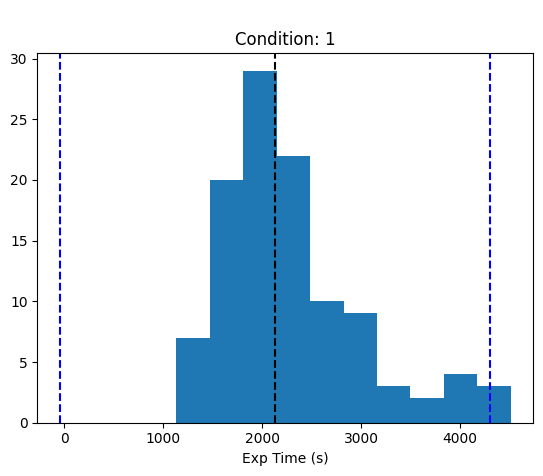

In [270]:
# Time taken per condition

exceeded_parts = []

for condition in [0,1]:
    print("\nCondition: " +str(condition))
    condition_df = complete_data.loc[complete_data.condition == condition]
    clength = condition_df.expLength
    mean = clength.mean()
    sd = clength.std()
    med = clength.median()
    print("Mean: " + str(mean/60))
    print("Std: " + str(sd/60))
    print("Median: " + str(med/60))
    
    time_exceed_df = condition_df.loc[(condition_df.expLength > med + 3*sd) | (condition_df.expLength < med - 3*sd)]
    exceeded_parts += list(time_exceed_df.workerId)
    
    plt.figure()
    plt.hist(clength)
    plt.axvline(med, linestyle='--', color='black')
    plt.axvline(med + 3*sd, linestyle='--', color='blue')
    plt.axvline(med - 3*sd, linestyle='--', color='blue')
    plt.title("\nCondition: " +str(condition))
    plt.xlabel("Exp Time (s)")
    
plt.show()


In [271]:
# Exclude based on time only with full dataset, not with partial dataset
exclude_time = True

In [272]:
# Excluding participants based on time

if exclude_time:
    within_time_parts = complete_data.loc[~complete_data.workerId.isin(exceeded_parts)]
else:
    within_time_parts = complete_data
print(len(within_time_parts.loc[within_time_parts.condition == 0]))
print(len(within_time_parts.loc[within_time_parts.condition == 1]))
print("\n")
for part in exceeded_parts:
    print(part, list(complete_data.loc[complete_data.workerId == part]["condition"])[0])

109
107


w91613593 0
w91869494 0
w79709549 0
w93382793 1
w32222186 1


In [273]:
if exclude_time:
    for p in exceeded_parts:
        excluded_parts.append({
            "workerId": p,
            "reason": "exceededTime"
        })

In [274]:
within_time_parts["effort"] = within_time_parts.effort.astype("int64")

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_6803/4083886449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  within_time_parts["effort"] = within_time_parts.effort.astype("int64")


In [275]:
# Excluding participants based on effort
ineffortful_parts = within_time_parts.loc[within_time_parts.effort > 1]
ineffortful_parts[["workerId", "condition", "effort"]]


,workerId,condition,effort
56,w82237922,0,3
78,w62159434,0,2
210,w50449936,1,3


In [276]:
effortful_parts = within_time_parts.loc[~within_time_parts.workerId.isin(list(ineffortful_parts.workerId))]
print(len(effortful_parts.loc[effortful_parts.condition == 0]))
print(len(effortful_parts.loc[effortful_parts.condition == 1]))


107
106


In [277]:
for p in ineffortful_parts.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "noeffort"
    })

In [278]:
# Excluding participants who already have done the task
for idx, (workerId, ans) in effortful_parts[["workerId","alreadyParticipated"]].iterrows():
    if "no" not in ans.lower() and "never" not in ans.lower():
        print(workerId, ans)

w89243441 yes, I did
w93289383 i dont believe i ever have completed one before this was a new experience and it was super fun look forward to seeing what bonus i get
w28105407 yes
w34625717 I don't believe I've done this before.
w83337711 Nah hadn't participated in a Web of Cash HIT before. But very interested on doing similar HITs.
w11309130 
w17783226 this was the first one
w32915339 N/A
w66301944 it was my first 
w70266858 yes
w99307795 This was my first time
w41244801 Yes, but this one was different. The inspected values only remained for a few seconds.
w31856307 NA
w39489135 this was my first time doing a web of cash HIT, or any other HIT for that matter
w74977008 I CANT REMEMBER
w40289780 yes
w62316961 It was my first time participating in this HIT 
w96010362 I am pretty sure I haven't played this game before.
w82728863 I haven't participated in a HIT game before. 


In [279]:
already_participated

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
66,w29615251,2023-09-01 15:06:00.079715,2023-09-01 15:38:57.251761,2023-09-01 15:07:18.319209,3,<redacted>,windows,en-GB,1977.0,1892.520,...,It was very difficult because I would end up l...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-642.40,1192.484,-700.036,20008.150,0.0
113,w64797713,2023-09-02 13:13:58.701066,2023-09-02 13:50:51.484930,2023-09-02 13:14:14.336608,3,<redacted>,windows,en-US,2212.0,2196.005,...,It wasn't difficult at all. i learnt the hard ...,"{'Q0': 'Strongly agree', 'Q1': 'Agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1472.80,1397.400,-798.605,26563.275,0.0
163,w83968328,2023-09-01 15:15:13.584577,2023-09-01 16:01:07.152388,2023-09-01 15:15:38.975849,3,<redacted>,windows,en-US,2753.0,2726.531,...,i found it easy,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1350.60,1990.921,-735.610,26848.100,0.0
265,w85568180,2023-08-31 11:55:40.584079,2023-08-31 12:47:50.628588,2023-08-31 11:56:02.330548,3,<redacted>,windows,en-US,3130.0,3043.462,...,it was not difficult to be honest. once you pl...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,2261.45,2292.554,-750.908,41930.450,0.0
315,w14885624,2023-09-04 13:37:41.898793,2023-09-04 14:25:42.041393,2023-09-04 13:37:58.858368,3,<redacted>,windows,en-ZA,2880.0,2860.642,...,Not so difficult.,"{'Q0': 'Agree', 'Q1': 'Agree', 'Q2': 'Neither ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,913.20,1988.254,-872.388,39716.100,0.0
335,w14730501,2023-08-31 11:35:33.169312,2023-08-31 12:16:17.812899,2023-08-31 11:35:45.035337,3,<redacted>,windows,en-US,2444.0,2431.957,...,"It wasn't too difficult, i just had to follow ...","{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1597.35,1689.853,-742.104,30970.750,0.0


In [280]:
# Already participated have to be filtered manually

already_participated_ids = ["w14885624", "w85568180", "w64797713", "w89243441", "w40289780", "w28105407",
                           "w29615251", "w14730501", "w83968328", "w41244801", "w70266858"]

already_participated = effortful_parts.loc[effortful_parts.workerId.isin(already_participated_ids)]
already_participated[["workerId", "condition"]]

,workerId,condition
3,w89243441,0
19,w28105407,1
108,w70266858,0
171,w41244801,0
262,w40289780,1


In [281]:
excluded_parts

[{'workerId': 'w60165223', 'reason': 'dropout'},
 {'workerId': 'w96919407', 'reason': 'dropout'},
 {'workerId': 'w47185265', 'reason': 'dropout'},
 {'workerId': 'w49351698', 'reason': 'dropout'},
 {'workerId': 'w49702558', 'reason': 'dropout'},
 {'workerId': 'w67047455', 'reason': 'dropout'},
 {'workerId': 'w78959733', 'reason': 'dropout'},
 {'workerId': 'w68466863', 'reason': 'dropout'},
 {'workerId': 'w11403524', 'reason': 'dropout'},
 {'workerId': 'w99177045', 'reason': 'dropout'},
 {'workerId': 'w71853600', 'reason': 'dropout'},
 {'workerId': 'w24603609', 'reason': 'dropout'},
 {'workerId': 'w18172158', 'reason': 'dropout'},
 {'workerId': 'w18885932', 'reason': 'quizfail'},
 {'workerId': 'w63037649', 'reason': 'quizfail'},
 {'workerId': 'w21896350', 'reason': 'quizfail'},
 {'workerId': 'w62511750', 'reason': 'quizfail'},
 {'workerId': 'w55299912', 'reason': 'quizfail'},
 {'workerId': 'w22059943', 'reason': 'quizfail'},
 {'workerId': 'w58691235', 'reason': 'quizfail'},
 {'workerId':

In [282]:
for p in already_participated.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "alreadyparticipated"
    })

In [283]:
new_parts = effortful_parts.loc[~effortful_parts.workerId.isin(already_participated_ids)]
print(len(new_parts.loc[new_parts.condition == 0]))
print(len(new_parts.loc[new_parts.condition == 1]))

104
104


In [284]:
# Participant data that is complete and that also has valid click strategies 

valid_click_strat_data = new_parts.loc[new_parts.clickStratsValid]
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 0]))
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
valid_click_strat_data

104
97


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,w11930620,2023-08-04 14:26:13.995660,NaT,2023-08-04 14:27:28.911138,6,<redacted>,windows,en-US,1575.046,1575.046,...,It was not too difficult to improve my perform...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1276.10,1141.303,-433.743,19817.350,0.0
1,w22592146,2023-08-04 14:32:32.503896,2023-08-04 15:08:59.197984,2023-08-04 14:32:49.743396,3,<redacted>,windows,en-GB,2186.000,2167.440,...,It was not that difficult. I just had to make ...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1383.50,1258.238,-909.202,21793.000,0.0
2,w20838185,2023-08-04 15:15:22.853993,2023-08-04 15:49:00.013875,2023-08-04 15:15:33.590384,3,<redacted>,windows,en-ZA,2017.000,2000.177,...,It was difficult because it was like every end...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-188.80,1254.960,-745.217,20300.325,0.0
4,w90625846,2023-08-03 15:32:10.375510,2023-08-03 15:56:13.909046,2023-08-03 15:32:15.763888,3,<redacted>,windows,en-GB,1443.000,1437.708,...,The randomness of the location of the big wort...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2033.80,1137.806,-299.902,24060.650,0.0
5,w51333812,2023-08-04 09:40:08.979578,2023-08-04 10:15:22.161489,2023-08-04 09:40:24.450885,3,<redacted>,macos,en-GB,2113.000,2096.673,...,keeping track of the highest node,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Disag...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,2015.35,1571.349,-525.324,32577.450,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,w20913252,2023-08-04 09:41:23.715693,2023-08-04 10:13:27.811889,2023-08-04 09:42:02.215872,3,<redacted>,windows,en-US,1924.000,1883.341,...,it wasn't really difficult to improve my perfo...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,475.00,1294.200,-589.141,21892.225,0.0
275,w36257203,2023-08-04 14:53:59.094854,2023-08-04 15:14:35.308963,2023-08-04 14:54:03.988015,3,<redacted>,windows,en-US,1236.000,1230.791,...,"I didn't improve much, I think the value at th...","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2201.55,1001.713,-229.078,21790.175,0.0
277,w28176366,2023-08-04 09:45:03.229233,2023-08-04 10:16:32.217887,2023-08-04 09:45:40.290667,3,<redacted>,windows,en-ZA,1888.000,1850.484,...,It was slightly difficult because of the money...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,616.20,1138.516,-711.968,20907.150,0.0
278,w60047818,2023-08-04 09:41:40.021480,2023-08-04 10:13:09.252172,2023-08-04 09:41:48.013314,3,<redacted>,windows,en-US,1889.000,1880.190,...,it was not that difficult,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,884.25,1031.119,-849.071,19314.325,0.0


In [285]:
# Excluding participants

invalid_click_strat_data = new_parts.loc[~new_parts.clickStratsValid]
for p in invalid_click_strat_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "invalidClickStrats"
    })

In [286]:
# Final score per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = new_parts.loc[new_parts.condition == condition].finalScore
    print("Mean: " + str(clength.mean()))
    print("Std: " + str(clength.std()))
    print("Median: " + str(clength.median()))


Condition: 0
Mean: 1167.1375000000003
Std: 915.7813626951079
Median: 1335.25

Condition: 1
Mean: 1039.858173076923
Std: 825.0966448573661
Median: 1245.6

Condition: 2
Mean: nan
Std: nan
Median: nan


In [287]:
# Updating all files of participants whose data should be excluded

for ep in excluded_parts:
    w = ep["workerId"]
    # Get the file name 
    file = [fn for fn in os.listdir(datafolder) if w in fn][0]
    fpath = datafolder + file
    # Read the json
    with open(fpath, 'r') as f:
        participant = json.load(f)
    # Add the fields
    participant["excludeReason"] = ep["reason"]
    # Rewrite the file
    with open(fpath, 'w') as fw:
        json.dump(participant, fw)
    print(f"Wrote to {file}: {ep['reason']}")
    
    

Wrote to full_o_4_w60165223.json: dropout
Wrote to full_o_3_w96919407.json: dropout
Wrote to full_o_2_w47185265.json: dropout
Wrote to full_o_3_w49351698.json: dropout
Wrote to full_o_3_w49702558.json: dropout
Wrote to full_o_3_w67047455.json: dropout
Wrote to full_o_5_w78959733.json: dropout
Wrote to full_o_4_w68466863.json: dropout
Wrote to full_o_2_w11403524.json: dropout
Wrote to full_o_4_w99177045.json: dropout
Wrote to full_o_5_w71853600.json: dropout
Wrote to full_o_3_w24603609.json: dropout
Wrote to full_o_3_w18172158.json: dropout
Wrote to full_o_3_w18885932.json: quizfail
Wrote to full_o_3_w63037649.json: quizfail
Wrote to full_o_3_w21896350.json: quizfail
Wrote to full_o_4_w62511750.json: quizfail
Wrote to full_o_2_w55299912.json: quizfail
Wrote to full_o_4_w22059943.json: quizfail
Wrote to full_o_4_w58691235.json: quizfail
Wrote to full_o_4_w17630596.json: quizfail
Wrote to full_o_2_w99745213.json: quizfail
Wrote to full_o_4_w31246579.json: quizfail
Wrote to full_o_3_w22109

In [232]:
sorted(list(new_parts.workerId))

['w10092073',
 'w10573274',
 'w10597662',
 'w11177063',
 'w11186246',
 'w12271574',
 'w12322810',
 'w13100309',
 'w13245283',
 'w13475977',
 'w14176872',
 'w14274734',
 'w14584874',
 'w14925228',
 'w15073287',
 'w16476295',
 'w16937372',
 'w17360819',
 'w18642308',
 'w18826734',
 'w19354974',
 'w19439893',
 'w19480958',
 'w19528032',
 'w20049511',
 'w20188397',
 'w20262211',
 'w20539671',
 'w20854806',
 'w21067498',
 'w21420348',
 'w21695759',
 'w21696427',
 'w21793705',
 'w22423378',
 'w22592551',
 'w22709195',
 'w23162235',
 'w23716629',
 'w23723043',
 'w24178968',
 'w25402310',
 'w25488418',
 'w25701305',
 'w26139069',
 'w26593215',
 'w27163576',
 'w27226158',
 'w27945393',
 'w28795148',
 'w28979187',
 'w29104725',
 'w29116851',
 'w29144631',
 'w29473610',
 'w29928502',
 'w30271393',
 'w30325068',
 'w30749725',
 'w31309762',
 'w31327541',
 'w31339064',
 'w31647799',
 'w31760974',
 'w31800484',
 'w31889251',
 'w32492313',
 'w32696540',
 'w32799476',
 'w32892584',
 'w33055757',
 'w331

In [233]:
def read_json(filepath):
    with open(filepath, 'r') as f:
        filestring = f.read()
        return json.loads(filestring)
    
def write_json(jsonobj, filepath):
    with open(filepath, 'w') as f:
        json.dump(jsonobj, f)

In [289]:
# Checking for consistency of excludeReasons between anonymized and not anonymized data

anonymized_data_folder = '../results/anonymized_data/'
data_folder = '../results/'
id_map_file = '../results/anonymized_id_map.json'

file_prefix = "full"

all_part_files = [filename for filename in os.listdir(data_folder) if filename.startswith(file_prefix) and 'results' not in filename]
all_part_paths = [data_folder + filename for filename in all_part_files]

anon_part_files = [filename for filename in os.listdir(anonymized_data_folder) if filename.startswith(file_prefix) and 'results' not in filename]
anon_part_paths = [anonymized_data_folder + filename for filename in anon_part_files]

id_map = read_json(id_map_file)

for file in all_part_paths:
    orig_part = read_json(file)
    workerId = orig_part["workerId"]
    anon_id = id_map['workerId'][workerId]
    anon_file_path = [f for f in anon_part_paths if anon_id in f][0]
    anon_part = read_json(anon_file_path)
    read_anon_id = anon_part['workerId']
    excludeReasonsEqual = True
    mistake = ""
    if "excludeReason" in orig_part:
        if "excludeReason" not in anon_part:
            excludeReasonsEqual = False
            mistake = "anonNotExclude: " + orig_part["excludeReason"]
        elif orig_part["excludeReason"] != anon_part["excludeReason"]:
            excludeReasonsEqual = False
            mistake = "inconsistent: " + orig_part["excludeReason"]
    else:
        if "excludeReason" in anon_part:
            excludeReasonsEqual = False
            mistake = "origNotExclude: " + anon_part["excludeReason"]
            
    print(workerId, anon_id, anon_id == read_anon_id, excludeReasonsEqual, mistake)
    
    


613789190e10970db0b4399f w11186246 True True 
596e1edd39e9d00001b7bb98 w45350335 True True 
614395b646280ec3c4ab1d49 w90627961 True True 
6139d8c791c9b4805690b33e w41586610 True True 
6159f5208087ddd970d727d1 w56211665 True True 
60f724fd8ec131e82a00b129 w33622262 True True 
5db050bee16e28001752bc92 w79792462 True True 
60cce1dff5946c42b4402084 w40033915 True True 
5f5547c3a0ac76108f69e767 w75430675 True True 
6137753896c9b6b5813a2432 w53698886 True True 
60f815535ea713f564c6ed61 w32492313 True True 
5b587d897846fa0001fc11c6 w60607342 True True 
612cb8236aa1cef2599e6f59 w63037649 True True 
61375098ac2bf903b0364ec3 w96919407 True True 
64803fe717b0a137be421ae1 w59242215 True True 
60da0dd4c8268e2d7125907e w26593215 True True 
616ed458582d2c3b50149493 w66729892 True True 
613758e7a80409ba7f5affb6 w83126098 True True 
5e8c13d8f743d210d47ec874 w43788815 True True 
5e72087440aeca126bf6326c w53929258 True True 
60dceeaa19d94b7d2651c389 w63533218 True True 
61702a081098614cd58391a8 w40509605

64a9858be9b52e570ffb3c1e w69843463 True True 
60643e9b1b2e851ff9238862 w79800428 True True 
615f4ddc420b1b75f246a4ec w93809484 True True 
64870c273788a56dd7aa0397 w27372122 True True 
60da20b656aa7f69fb3d8f6b w27232243 True True 
5f78a12acd4a784585c83337 w80168495 True True 
61504e85a1e23353a05dd8fa w52838368 True True 
6152f8ecefde7f8298316ee6 w31246579 True True 
605de3af48d7a575adb95b09 w70266858 True True 
63e51e063af1cc5baf0c72ca w20049511 True True 
6153554048e1825ac1946e84 w56991682 True True 
5ef9b70e432ef80119d3d829 w96602360 True True 
5d5193ce23e3ae0001f5f262 w12322810 True True 
62ab29bfb1c80887f36dfcf3 w89459375 True True 
59ba6e9162b30d0001b7acab w10775855 True True 
611d83fbcd4d624e50515f20 w60237886 True True 
6161b89b2318b608686deb14 w27163576 True True 
60fe791fd76e549081dca7ab w47079964 True True 
5f003e622ec97b13f2764ec9 w32696540 True True 
62e2917bb46ebde5c7866071 w90625846 True True 
5e459f61418f610891628564 w88356372 True True 
60b880518b31da36270782eb w66708417

601129f77e0c21000b0c408a w21696427 True True 
6102db96d41a4bf54acd678b w10573274 True True 
60eccd4d9b4a0c1f4ab919a4 w64797713 True True 
63ef938aea545fb9bd19a591 w25488418 True True 
613018599782583980fbf406 w32685957 True True 
6160c9e6ef711c4b5d7f0de8 w58095681 True True 
60a6c3c07faa496010254d09 w21420348 True True 
5f6cc4a84b851e0bb2028bb9 w69986083 True True 
6176b584db27cdcecc3896c8 w78860763 True True 
613d0ef50abfe24aa600bc84 w20838185 True True 
5ec96e3609117f0a67231842 w13100309 True True 
611e4aad7f8f811ba1871763 w58197514 True True 
5bbd2bdcf7358a000171636f w77642613 True True 
5f2428a843b54d0008905e34 w66204036 True True 
612cdaa2042b4d9b9fb16acd w10092073 True True 
64e488a7ee38c01b51f9e2d3 w84095686 True True 
612493c552963eed123a9dba w31042533 True True 
60b005fde343f75a2b76d406 w91959996 True True 
60b94f837bfda8b1977feef0 w80390260 True True 
611a877bcd96a7f29f70230a w43384380 True True 
646baaaa73f3e86f2af26ac8 w53154873 True True 
5c7ceda01d2afc0001f4ad1d w42007853

5d64426653ba680017d9f63a w33234998 True True 
6102a714924dfb65fe21175b w41178685 True True 
60e81342fbceb05029e8f5d9 w43871272 True True 
5b9d57e5737d030001ad2cbf w75195348 True True 
62fd350caefba1a1ec979664 w89143715 True True 
60e46765548980c44f6a1edc w54160308 True True 
5c49feff71e01d00019376a6 w72210178 True True 
615ecf8f907bfe51f5a09f00 w14788080 True True 
617142c2a843eef6f8f148b6 w25779052 True True 
60f00946830b1ef95b23b166 w17360819 True True 
5de60f418f5cd559c333199c w81274284 True True 
5d4aebdd54ad1e001abee843 w56272024 True True 
6091bcc967016811f0f05489 w99333353 True True 
5f0f4e2e850b230eb3e7bb95 w20419254 True True 
612530f3e28f8c909170bf0a w61473455 True True 
60fff1bb5655b461b15f8a8c w58651604 True True 
631a1dc31cb107f36694e744 w53171787 True True 
6075e12159e69162ee283711 w86212523 True True 
611ce44efa3822c780ae383e w23786950 True True 
5fe848f115b59b69cf9b06b6 w88820466 True True 
5e8e38da572c650e2ede51c9 w31856307 True True 
5ea96886ef7ece0604eee527 w63749147

In [180]:
# Remove the exclude reason to reset files to original state

anonymized_data_folder = '../results/anonymized_data/'
# data_folder = '../results/'
id_map_file = '../results/anonymized_id_map.json'

file_prefix = "full_r"

# all_part_files = [filename for filename in os.listdir(data_folder) if filename.startswith(fileprefix) and 'results' not in filename]
# all_part_paths = [data_folder + filename for filename in all_part_files]

anon_part_files = [filename for filename in os.listdir(anonymized_data_folder) if filename.startswith(file_prefix) and 'results' not in filename]
anon_part_paths = [anonymized_data_folder + filename for filename in anon_part_files]

id_map = read_json(id_map_file)

for file in anon_part_paths:
    anon_part = read_json(file)
    try:
        del anon_part["excludeReason"]
    except:
        continue
    
    write_json(anon_part, file)
    print(f"Removed excludeReason for {file}")


# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [46]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [48]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [53]:
scarce_complete = new_parts[new_parts.condition == 1]
control_complete = new_parts[new_parts.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in new_parts.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            if trial_count > 40: 
                print(workerId)
                continue
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 5,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

In [54]:
# Write to CSV file

with open('../results/mcl_toolbox/mouselab-mdp-final-misaligned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [55]:
# Write to CSV file

with open('../results/mcl_toolbox/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [59]:
len(complete_data)

329

In [60]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: No.
Already participated: No, have never participated before.


Feedback: No, all seemed straightforward
Already participated: No, I haven't.
Comments: Was fun, thanks :)


Already participated: 26
Comments: male


Feedback: yes, it was complicated
Already participated: 26
Comments: male


Feedback: No, the experiment was clear.
Already participated: No, I hadn't.
Comments: None.


Feedback: I seemed to have more time to use the node inspector that I initially thought.  I thought I only had 3 seconds in total to check as many nodes as possible. but I soon realised how this worked.
Already participated: No
Comments: I enjoyed that, Thank you.


Feedback: Not at all.
Already participated: No.


Feedback: Not at all
Already participated: No I never did a HIT Game before.


Feedback: No
Already participated: No


Feedback: Nothing was difficult to understand, the instructions were clear and easy.
Already participated: I have never participated in this game before.


Feedback: It 

In [61]:
# Demographics:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}

ages = {
    "all" : which_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]

try:
    num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["all"] = 0

for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    ages[cond] = sub_df["age"].astype("int")
    gender_unique, gender_counts = np.unique(sub_df.gender, return_counts=True)
    genders = np.asarray((gender_unique, gender_counts)).T
    num_male[cond] = genders[np.where(genders[:,0] == "male")[0][0], 1]
    num_female[cond] = genders[np.where(genders[:,0] == "female")[0][0], 1]
    try:
        num_other[cond] = genders[np.where(genders[:,0] == "other")[0][0], 1]
    except:
        num_other[cond] = 0


efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMean: {0:0.3f}".format(ages[cond].mean()))
    print("\t\tSD: {0:0.3f}".format(ages[cond].std()))
    print("\t\tMedian: {0:0.3f}".format(ages[cond].median()))
    print("\t\tMax: {0:0.3f}".format(ages[cond].max()))
    print("\t\tMin: {0:0.3f}".format(ages[cond].min()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMale: {0} ({1:0.2f}%)".format(num_male[cond], (100 * num_male[cond] / len(sub_df))))
    print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female[cond], (100 * num_female[cond] / len(sub_df))))
    print("\t\tOther: {0} ({1:0.2f}%)".format(num_other[cond], (100 * num_other[cond] / len(sub_df))))


Age stats:
	Overall:
		Mean: 31.971
		SD: 11.621
		Median: 29.000
		Max: 67.000
		Min: -31.000
	Control:
		Mean: 32.401
		SD: 10.892
		Median: 29.000
		Max: 67.000
		Min: 19.000
	Misaligned:
		Mean: 31.560
		SD: 12.298
		Median: 29.000
		Max: 67.000
		Min: -31.000
Gender stats:
	Overall:
		Male: 131 (42.12%)
		Female: 177 (56.91%)
		Other: 3 (0.96%)
	Control:
		Male: 58 (38.16%)
		Female: 93 (61.18%)
		Other: 1 (0.66%)
	Misaligned:
		Male: 73 (45.91%)
		Female: 84 (52.83%)
		Other: 2 (1.26%)


In [62]:
# Effort:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}


for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    print("\n" + conditions[cond])
    print(sub_df["effort"].value_counts())




Control
effort
0    137
1     15
Name: count, dtype: int64

Misaligned
effort
0    135
1     24
Name: count, dtype: int64


In [63]:
# Comments on difficulty and strategy - all conditions

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        if len(part["whatStrategy"]) > 0:
            print("Strategy Used: " + part["whatStrategy"])
            printed = True
        if len(part["strategyImprove"]) > 0:
            print("How strategy was improved: " + part["strategyImprove"])
            printed = True
        if len(part["difficult"]) > 0:
            print("Difficulty: " + part["difficult"])
            printed = True
        if printed:
            print("\n")


------ Control ------

Strategy Used: I used the nodes inspector on the nodes which I thought would be my end target to see if I was satisfied with the amount, if it was a decent credit I would head to that node.  I tried to see the value of few a nodes as possible to save the expense
How strategy was improved: I'm not sure I did, if at all only by using the node inspector less.
Difficulty: I was happy with my performance after I concentrated on reaching an end node with a decent credit to aim for.  So long as I was in credit that was OK.  I did get frustrated a couple of times and headed off with no particular target after using the node inspector and not seeing a credit amount, but at least I had an idea of not where to head.


Strategy Used: I choose the path that give me positive point the most.
How strategy was improved: Yes, The path that give me negatives most of the time I did not use very often
Difficulty: No much.


Strategy Used: To view the last nodes and see which one has

In [1]:
# Stats on self-report of clicks at first level - all conditions

questions = {
    "Q0": "In most rounds, I clicked the nodes at the first level.",
    "Q1": "When ..., it was ONLY to receive the immediate $0.25 reward.",
    "Q2": "When ..., it was NOT ONLY to receive the immediate $0.25 reward.",
    "Q3": "When ..., I did it to see the numbers that were present at those nodes.",
    "Q4": "When ..., I did for another reason than to see the numbers that were present at those nodes.",
    "Q5": "When ..., I paid attention to the numbers that were present at those nodes.",
    "Q6": "When ..., I did NOT pay attention to the numbers that were present at those nodes."
}

longest_q_len = max([len(a) for a in questions.values()])

df_dicts = []

# Pad answers with spaces
for q in questions.keys():
    qtext = questions[q]
    questions[q] += "".join([" "] * (longest_q_len - len(qtext)))

answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
answer_abbr_map = {a: ''.join([w[0] for w in a.split(" ")]).upper() for a in answers}

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        if part['workerId'] not in list(complete_data.workerId): continue
        printed = False
        prop_L1clicks = sum([bool(c) for c in part["clicksL1"]])/len(part["clicksL1"])
        if prop_L1clicks < 0.1: continue
        print("\n", part["workerId"], part["clickStratsValid"], prop_L1clicks)
        for qnum, ans in part["firstLevelAns"].items():
            print(questions[qnum], "\t", answer_abbr_map[ans])#answers.index(ans))
        dict_ = {k: answers.index(v) for (k,v) in part["firstLevelAns"].items()}
        dict_["cL1_mean"] = np.mean(part["clicksL1"])
        df_dicts.append(dict_)
        printed = True
        if printed:
            print("\n")
            
strategy_ans_df = pd.DataFrame.from_dict(df_dicts).dropna()

NameError: name 'conditions' is not defined

0.5524836588213468


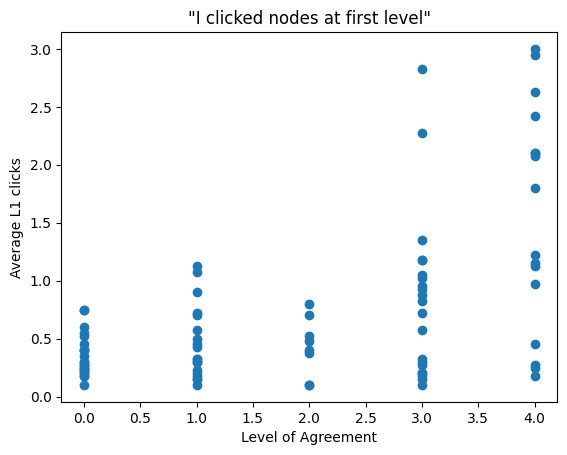

In [65]:
print(strategy_ans_df["Q0"].corr(strategy_ans_df["cL1_mean"]))
plt.scatter(strategy_ans_df["Q0"], strategy_ans_df["cL1_mean"])
plt.title("\"I clicked nodes at first level\"")
plt.xlabel("Level of Agreement")
plt.ylabel("Average L1 clicks")
plt.show()

In [113]:
strategy_ans_df["Q4"].value_counts().sort_index()

Q4
0.0    5
1.0    4
2.0    3
4.0    2
Name: count, dtype: int64

In [156]:
strategy_ans_df.where(strategy_ans_df > 2, 100)

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,3.0,100.0,100.0,100.0,3.0,100.00
1,3.0,100.0,3.0,100.0,3.0,100.00
2,100.0,100.0,3.0,100.0,100.0,100.00
3,4.0,100.0,4.0,4.0,100.0,100.00
4,3.0,100.0,100.0,3.0,100.0,100.00
5,3.0,100.0,100.0,3.0,100.0,100.00
6,100.0,100.0,100.0,100.0,100.0,100.00
8,4.0,100.0,3.0,100.0,3.0,100.00
9,100.0,3.0,100.0,4.0,4.0,100.00
10,100.0,100.0,100.0,3.0,100.0,100.00


In [165]:
agreement_df == 2

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,True,False
6,False,False,False,False,False,False
8,False,True,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False


In [172]:
agreement_df = strategy_ans_df.copy()
agreement_df = agreement_df.where(agreement_df >= 2, -1)
agreement_df = agreement_df.where(agreement_df <= 2, 1)
agreement_df = agreement_df.where(agreement_df != 2, 0)
agreement_df["cL1_mean"] = strategy_ans_df["cL1_mean"]

agreement_df

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,1.0,-1.0,-1.0,-1.0,1.0,0.12
1,1.0,-1.0,1.0,-1.0,1.0,0.36
2,-1.0,-1.0,1.0,-1.0,0.0,0.04
3,1.0,-1.0,1.0,1.0,-1.0,1.96
4,1.0,-1.0,-1.0,1.0,-1.0,0.00
5,1.0,-1.0,-1.0,1.0,0.0,0.60
6,-1.0,-1.0,-1.0,-1.0,-1.0,0.00
8,1.0,0.0,1.0,-1.0,1.0,0.00
9,-1.0,1.0,-1.0,1.0,1.0,0.28
10,-1.0,-1.0,-1.0,1.0,-1.0,0.00


In [176]:
(agreement_df["Q1"] + agreement_df["Q2"]).value_counts()

 0.0    13
-2.0    10
-1.0     4
 1.0     2
Name: count, dtype: int64

In [85]:
correct_answers = {
    "Q0": "$-2 to $2",
    "Q1": "$-16 to $16",
    "Q2": "$-88 to $88"
}

num_correct = {}
questions_correct = {}
bonus = {}

for cond in conditions.keys():
    num_correct[cond] = []
    questions_correct[cond] = {
        "Q0": 0,
        "Q1": 0,
        "Q2": 0
    }
    bonus[cond] = []
    sub_df = complete_data.loc[complete_data.condition == cond]
    for idx, row in sub_df.iterrows():
        part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
        part_answers = part['final_quiz_responses']
        part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
        num_correct[cond].append(part_correct_answers)
        for q in correct_answers.keys():
            questions_correct[cond][q] += int(part_answers[q] == correct_answers[q])
        part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
        bonus[cond].append(part_bonus)



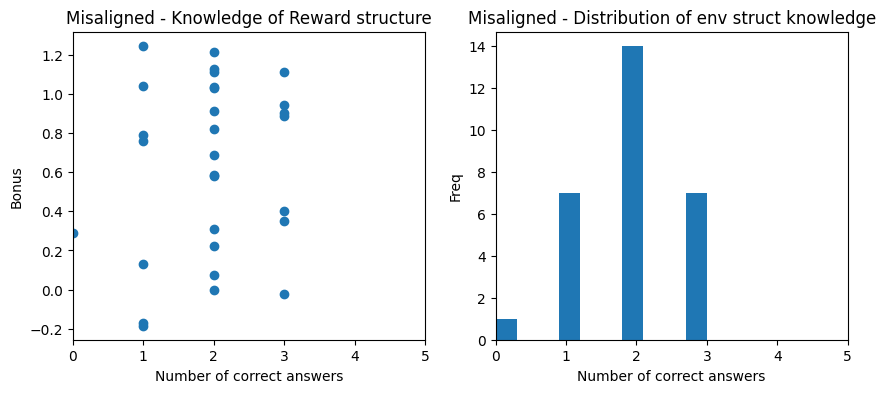

In [86]:


for idx, (cond, condname) in enumerate(conditions.items()):
    plt.figure(figsize=(5 * 2,4 * len(conditions)))
    plt.subplot(1,2,1)
    plt.scatter(num_correct[cond], bonus[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Bonus")
    plt.title(f"{condname} - Knowledge of Reward structure")
    plt.xlim([0,5])
    plt.subplot(1,2,2)
    plt.hist(num_correct[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Freq")
    plt.xlim([0,5])
    plt.title(f"{condname} - Distribution of env struct knowledge")

plt.show()

In [87]:
questions_correct

{0: {'Q0': 20, 'Q1': 13, 'Q2': 23}}